In [9]:
from numba.cpython.slicing import slice_indices

from case_studies.shadow_rbm.rbm_shadow_amp import free_energy_model_vals
%reload_ext autoreload
%autoreload 2

from lib.formatting import bitstring_to_int
from lib.data_loading import load_measurements, MixedDataLoader
from lib.state_io import load_state_vector

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence, Callable

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
from jax.random import PRNGKey
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn
from jaxtyping import PyTree

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506131516_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506131516_0


In [44]:
class ConditionalRBM(nn.Module):
    num_visible: int
    num_hidden: int
    conditioner_width: int = 64
    k: int = 1
    T: float = 1.0
    l2_strength: float = 1e-4
    num_chains: int = 100  # NEW PARAMETER

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)

        self.W = self.variable("amp", "W", zeros, (self.num_visible, self.num_hidden))
        self.b = self.variable("amp", "b", zeros, (self.num_visible,))
        self.c = self.variable("amp", "c", zeros, (self.num_hidden,))

    @nn.compact
    def conditioner(self, cond_basis: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        # cond_basis: (B, N, 4)
        x = nn.Dense(self.conditioner_width)(cond_basis)        # (B, N, D)
        x = nn.tanh(x)
        x = x.reshape(x.shape[0], -1)                           # (B, N*D)
        x = nn.Dense(2 * (self.num_visible + self.num_hidden))(x)  # (B, 2*(N+H))

        split_indices = [self.num_visible, 2 * self.num_visible, 2 * self.num_visible + self.num_hidden]
        gamma_b, beta_b, gamma_c, beta_c = jnp.split(x, split_indices, axis=-1)
        return gamma_b, beta_b, gamma_c, beta_c

    @staticmethod
    def decode_measurement_basis(cond_bits: jnp.ndarray) -> jnp.ndarray:
        # cond_bits: (B, N, 2)
        high_bit = cond_bits[..., 0]
        low_bit = cond_bits[..., 1]
        idx = high_bit * 2 + low_bit
        return jax.nn.one_hot(idx, 4, dtype=jnp.float32)  # (B, N, 4)

    def _free_energy(self, v: jnp.ndarray, b_mod: jnp.ndarray, c_mod: jnp.ndarray) -> jnp.ndarray:
        lin_term = -jnp.sum(v * b_mod, axis=-1)  # batched b
        hidden_term = jnp.sum(jax.nn.softplus(v @ self.W.value + c_mod), axis=-1)
        return lin_term - hidden_term

    @staticmethod
    def _gibbs_step(state: Tuple[jnp.ndarray, PRNGKey], W: jnp.ndarray, b: jnp.ndarray, c: jnp.ndarray, T: float):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    def __call__(self, batch: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        # splitting the batch into data and conditions
        v_data = batch[:, :, 0].astype(jnp.float32)             # (B, N)
        cond_bits = batch[:, :, 1:].astype(jnp.int32)           # (B, N, 2)
        cond_basis = self.decode_measurement_basis(cond_bits)   # (B, N, 4)

        # ewe get a conditioned bias per sample
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond_basis)
        b = (1.0 + gamma_b) * self.b.value + beta_b    # (B, N)
        c = (1.0 + gamma_c) * self.c.value + beta_c    # (B, H)

        # Randomly initialized M > B chains
        key, key_init = jax.random.split(aux_vars["key"])
        v_model = jax.random.bernoulli(key_init, 0.5, shape=(self.num_chains, self.num_visible)).astype(jnp.float32)

        # Use batch-averaged bias for model chains
        b_mean = b.mean(axis=0)  # (N,)
        c_mean = c.mean(axis=0)  # (H,)

        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W.value, b_mean, c_mean, self.T)
        v_model, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (v_model, key))
        v_model = jax.lax.stop_gradient(v_model)

        free_energy_data = self._free_energy(v_data, b, c)
        free_energy_model = self._free_energy(v_model, b_mean, c_mean)

        contrastive_divergence = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)
        l2_term = self.l2_strength * (jnp.sum(beta_b ** 2) + jnp.sum(beta_c ** 2))
        loss = contrastive_divergence + l2_term

        aux_vars_out = {
            "key": key,
            "free_energy_data": jnp.mean(free_energy_data),
            "free_energy_model": jnp.mean(free_energy_model),
        }

        return loss, aux_vars_out

In [45]:
@jax.jit
def train_step(state: TrainState, amp_vars: dict, batch: jnp.ndarray, key: PRNGKey) -> Tuple[TrainState, jnp.ndarray]:

    aux_vars = { "key": key }
    loss_fn = lambda params: state.apply_fn({'params': state.params, 'amp': amp_vars}, batch, aux_vars)

    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux_vars["free_energy_data"], aux_vars["free_energy_model"]


def train(
        state: TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader: MixedDataLoader,
        num_epochs: int,
        key: PRNGKey) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    for epoch in range(num_epochs):
        tot_loss = 0.0

        for batch in loader:
            key, key_batch = jax.random.split(key)
            state, loss, free_energy_data, free_energy_model = train_step(state, amp_vars, batch, key)
            tot_loss += float(loss)

        avg_loss = tot_loss / len(loader)
        lr = float(lr_schedule(state.opt_state[0].count))

        metrics[epoch] = dict(loss=avg_loss, lr=lr,
                              free_energy_data=free_energy_data, free_energy_model=free_energy_model)

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
                f"Free Energy Data: {free_energy_data:+.4f} │ "
                f"Free Energy Model: {free_energy_model:+.4f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [46]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

vars_amp = {"W": params_amp["W"], "b": params_amp["b"], "c": params_amp["c"]}

In [47]:
file_path = Path("data/w_aug_8MIXED_30000.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 30000/30000 [00:01<00:00, 22712.41it/s]


In [48]:
batch_size    = 64
num_visible = 8
num_hidden  = 8
num_epochs    = 200
init_lr      = 1e-2             # large drives modes down fast but learns nothing, to small and we dont get any one hots
final_lr     = init_lr * 0.1
l2_strength = 0.1

key = jax.random.PRNGKey(0)

key, key_params, key_dummy = jax.random.split(key, 3)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, conditioner_width=64, k=10)

batch_dummy = jnp.zeros((batch_size, num_visible, 3), dtype=jnp.float32)
aux_vars_dummy = { "key": key_dummy, "l2_strength": l2_strength}
variables = model.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader = MixedDataLoader(data, batch_size=batch_size)

schedule_steps = num_epochs * len(loader)
lr_schedule = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optim = optax.adam(lr_schedule)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optim)

state, metrics = train(state, vars_amp, loader, num_epochs, key)

Epoch 1/200 │ Loss: +13.7317 │ Free Energy Data: +8.6636 │ Free Energy Model: -8.2182 │ Learning Rate: 0.01000
Epoch 2/200 │ Loss: +13.7196 │ Free Energy Data: +4.4167 │ Free Energy Model: -8.2223 │ Learning Rate: 0.01000
Epoch 3/200 │ Loss: +13.7102 │ Free Energy Data: +3.8098 │ Free Energy Model: -8.2100 │ Learning Rate: 0.01000
Epoch 4/200 │ Loss: +13.7217 │ Free Energy Data: +7.9734 │ Free Energy Model: -8.2592 │ Learning Rate: 0.01000
Epoch 5/200 │ Loss: +13.7252 │ Free Energy Data: +6.2314 │ Free Energy Model: -8.5415 │ Learning Rate: 0.01000
Epoch 6/200 │ Loss: +13.7270 │ Free Energy Data: +4.8714 │ Free Energy Model: -8.1648 │ Learning Rate: 0.01000
Epoch 7/200 │ Loss: +13.7151 │ Free Energy Data: +7.0226 │ Free Energy Model: -8.7493 │ Learning Rate: 0.01000
Epoch 8/200 │ Loss: +13.7195 │ Free Energy Data: +6.4892 │ Free Energy Model: -8.1276 │ Learning Rate: 0.01000
Epoch 9/200 │ Loss: +13.7262 │ Free Energy Data: +8.9026 │ Free Energy Model: -8.3883 │ Learning Rate: 0.01000
E

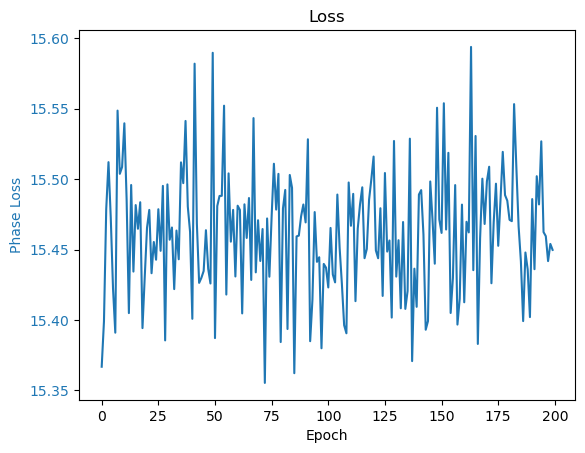

In [41]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]


fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()

ax2.plot(epochs, free_energy_model_vals, label="Free Energy Model", color="tab:orange")
ax2.plot(epochs, free_energy_data_vals, label="Free Energy Data", color="tab:green")
ax2.set_ylabel("Free Energy", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.set_ylabel("Learning Rate", color="tab:red")


plt.title("Loss")
plt.show()